In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tqdm import tqdm
import cv2
import numpy as np
import pydot

In [2]:
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc


from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom


from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

In [4]:
from os import listdir
from os.path import isfile, join
DATA_PATH = 'data/images'

In [5]:
classes = listdir(DATA_PATH)
print(len(classes))

120


In [6]:
stats = []
for each in classes:
    train_count = len(listdir(join(DATA_PATH, each)))
    stats.append([train_count, each])

In [7]:
stats.sort()

In [8]:
stats[-8:]

[[214, 'n02086240-Shih-Tzu'],
 [218, 'n02090721-Irish_wolfhound'],
 [218, 'n02107683-Bernese_mountain_dog'],
 [218, 'n02111889-Samoyed'],
 [219, 'n02112018-Pomeranian'],
 [232, 'n02092002-Scottish_deerhound'],
 [239, 'n02088094-Afghan_hound'],
 [252, 'n02085936-Maltese_dog']]

In [9]:
shortlisted = ['n02107683-Bernese_mountain_dog', 'n02088094-Afghan_hound', 'n02112018-Pomeranian', 'n02092002-Scottish_deerhound', 'n02099601-golden_retriever']

In [10]:
X = []
Z = []
imgsize = 150

In [11]:
def training_data(label,data_dir):
    for img in tqdm(listdir(data_dir)):
        path = join(data_dir,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(imgsize,imgsize))
        
        X.append(np.array(img))
        Z.append(str(label))

In [12]:
paths=[]

for index, dog in enumerate(shortlisted):
    path = join(DATA_PATH, dog)
    images = listdir(path)
    label = dog.split('-')[-1]
    training_data(label, path)

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 398.14it/s]


In [13]:
X = np.array(X)

In [14]:
X = X/255

In [15]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Z)
Y = to_categorical(Y, len(shortlisted))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

In [17]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(793, 150, 150, 3) (793, 5)
(265, 150, 150, 3) (265, 5)


In [18]:
img_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False) 

img_gen.fit(X_train)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001F7210FFB80> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F72290F3D0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F72290FC10> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F722912A00> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F722923730> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F722929280> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F71FF9C0A0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F7229446D0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F722930550> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F72293EB20> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F72291BFD0> False
<tensorflow.python.

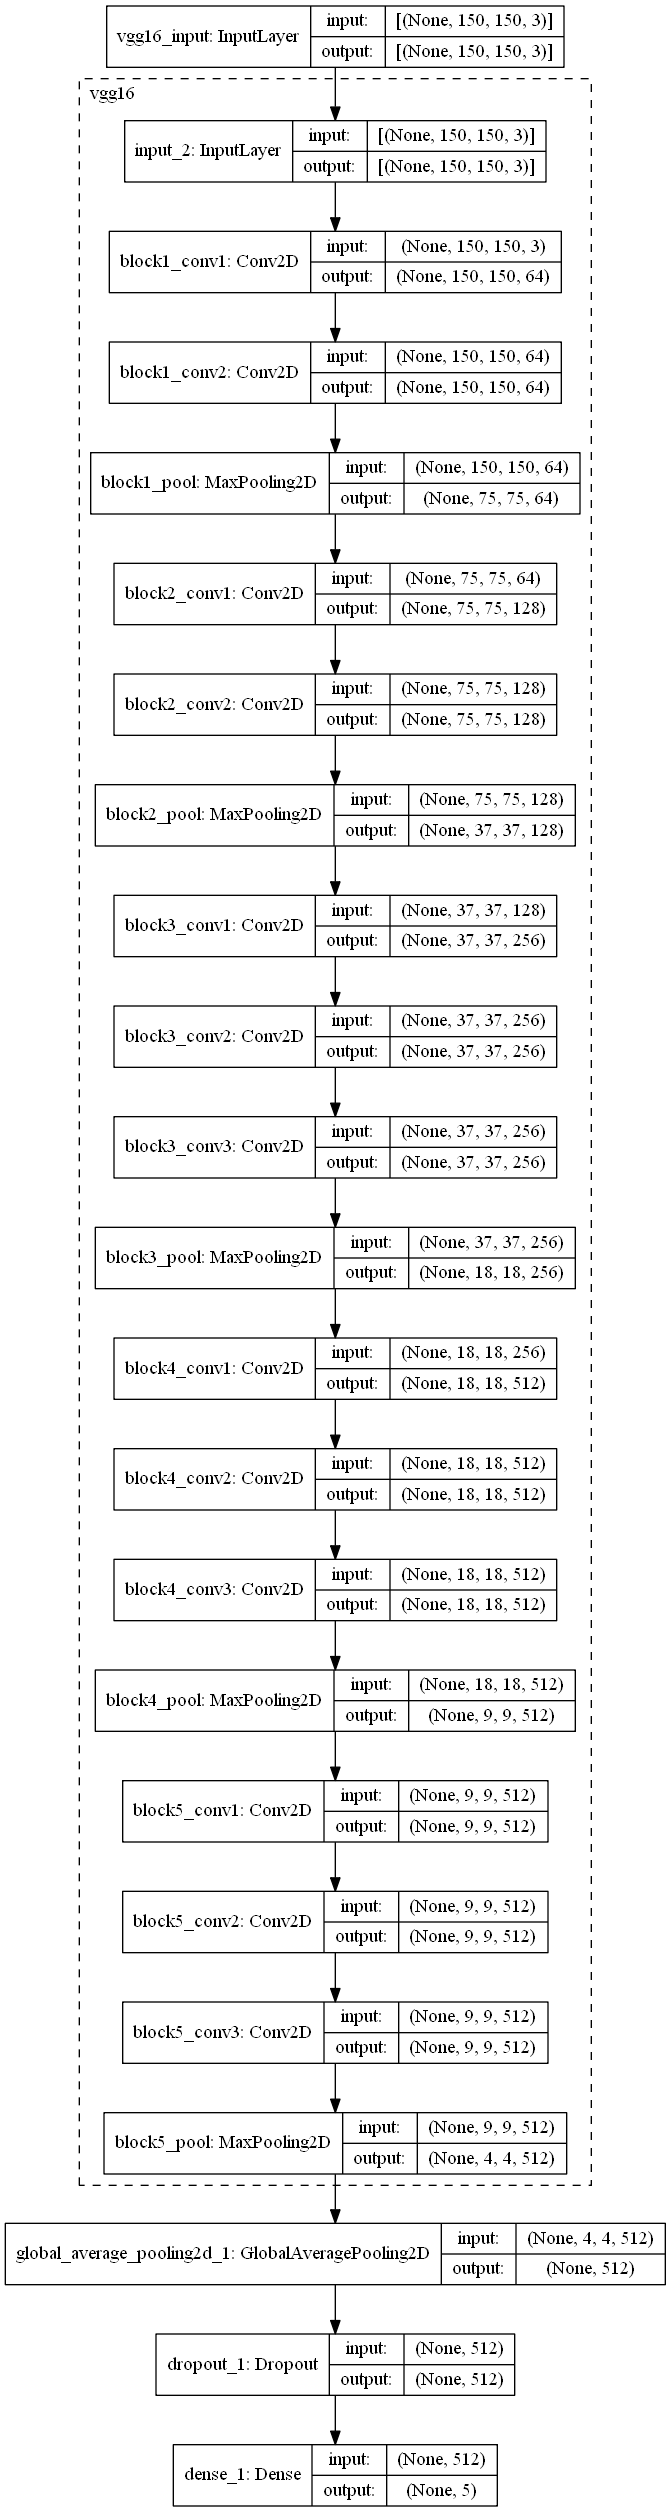

In [24]:
base_model = VGG16(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False
    
for layer in base_model.layers:
    print(layer,layer.trainable)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(len(shortlisted),activation='softmax'))
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [25]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [32]:
#-----------Optimizers-----------#
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-2)
#----------Compile---------------#
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
#-----------Training------------#
history = model.fit_generator(
    img_gen.flow(X_train,y_train,batch_size=16),
    validation_data  = (X_test,y_test),
    validation_steps = 30,
    steps_per_epoch  =30,
    epochs = 25,
    verbose = 1,
    callbacks=callbacks
)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
30/30 [==============================] - 30s 964ms/step - loss: 1.1723 - accuracy: 0.5592 - val_loss: 1.0944 - val_accuracy: 0.6679

Epoch 00001: val_loss improved from 1.16983 to 1.09435, saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets
Epoch 2/25
30/30 [==============================] - 25s 851ms/step - loss: 1.1450 - accuracy: 0.5713 - val_loss: 1.0648 - val_accuracy: 0.6415

Epoch 00002: val_loss improved from 1.09435 to 1.06479, saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets
Epoch 3/25
30/30 [==============================] - 25s 848ms/step - loss: 1.1171 - accuracy: 0.6190 - val_loss: 1.0439 - val_accuracy: 0.6377

Epoch 00003: val_loss improved from 1.06479 to 1.04394, saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets
Epoch 4/25
30/30 [==============================] - 26s 860ms/step - loss: 1.0322 - accuracy: 0.6258 - val_loss: 1.0145 - val_accuracy: 0.6717

Epoc

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001F7208CEA60> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F74B562460> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F721917790> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F73648E460> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F720E18520> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F720682C70> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F74B574880> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F74F042A00> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F7211905B0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F74F042820> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F74B5740D0> False
<tensorflow.python.

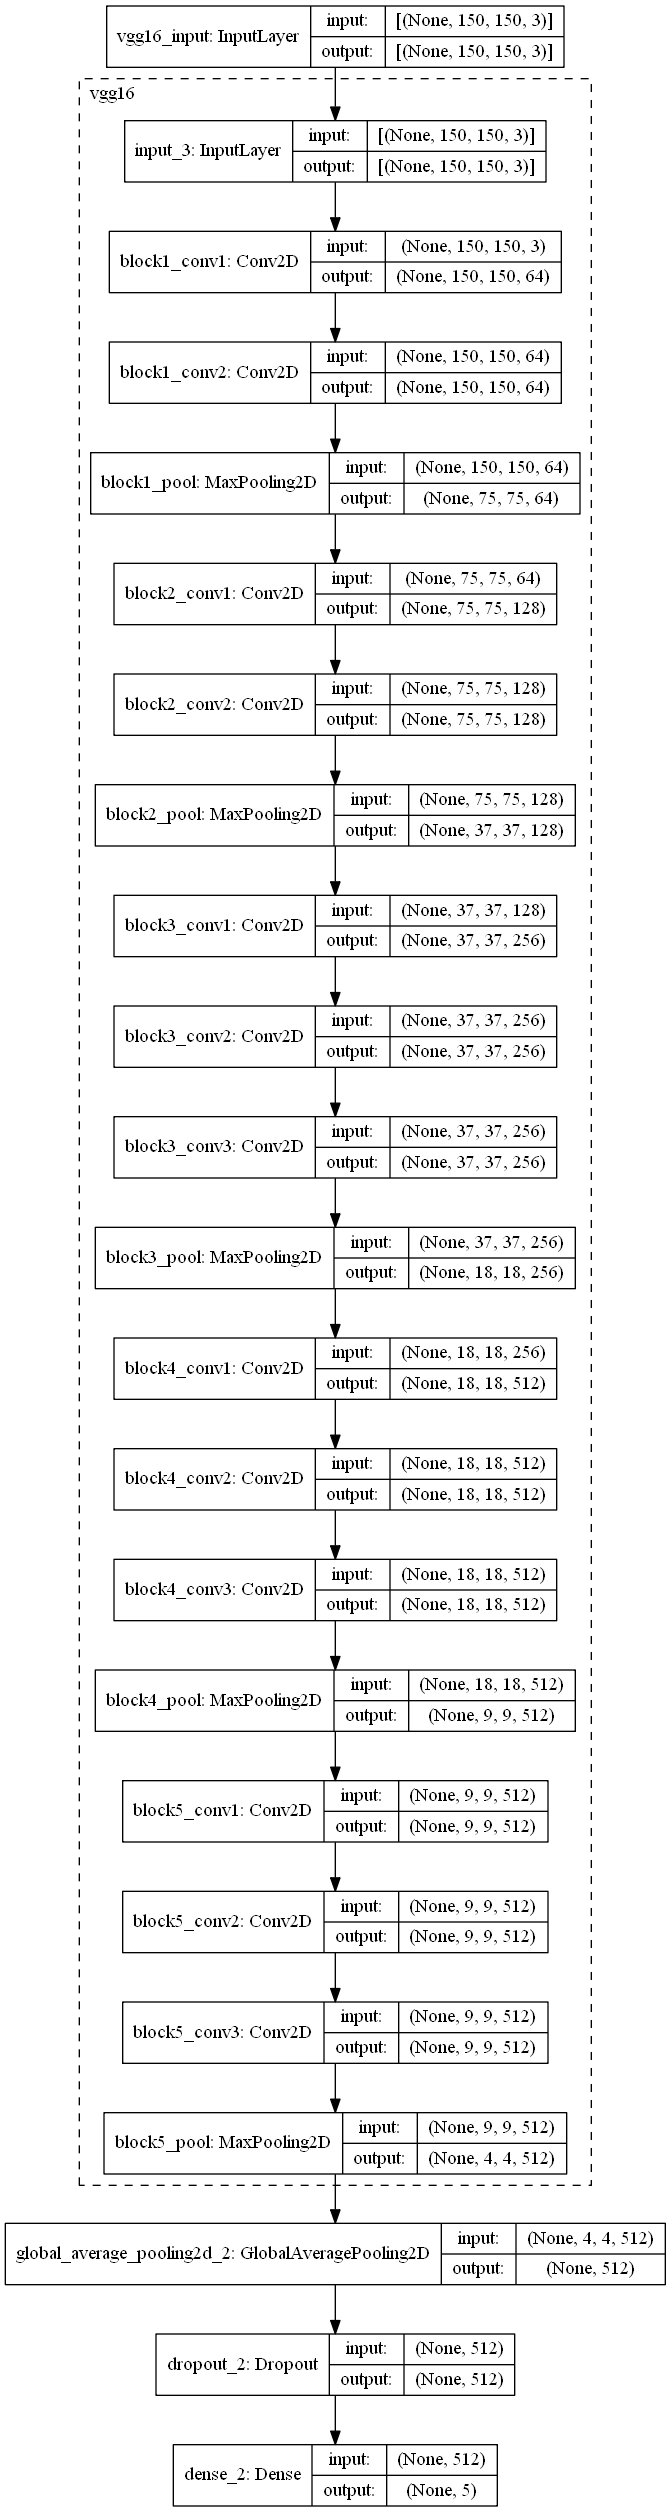

In [33]:
base_model1 = VGG16(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')

for layer in base_model1.layers[:-1]:
    layer.trainable = False
    
for layer in base_model1.layers:
    print(layer,layer.trainable)

model1 = Sequential()
model1.add(base_model1)
model1.add(GlobalAveragePooling2D())
model1.add(Dropout(0.5))
model1.add(Dense(len(shortlisted),activation='softmax'))
model1.summary()

SVG(model_to_dot(model1).create(prog='dot', format='svg'))
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [36]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [37]:
#-----------Optimizers-----------#
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-2)
#----------Compile---------------#
model1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
#-----------Training------------#
history = model1.fit_generator(
    img_gen.flow(X_train,y_train,batch_size=16),
    validation_data  = (X_test,y_test),
    validation_steps = 30,
    steps_per_epoch  = 35 ,
    epochs = 20,
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/20
35/35 [==============================] - 33s 892ms/step - loss: 1.5985 - accuracy: 0.2746 - val_loss: 1.3558 - val_accuracy: 0.5208

Epoch 00001: val_loss improved from inf to 1.35575, saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets
Epoch 2/20
35/35 [==============================] - 28s 806ms/step - loss: 1.4249 - accuracy: 0.4004 - val_loss: 1.2771 - val_accuracy: 0.6000

Epoch 00002: val_loss improved from 1.35575 to 1.27712, saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets
Epoch 3/20
35/35 [==============================] - 28s 809ms/step - loss: 1.3843 - accuracy: 0.4149 - val_loss: 1.2195 - val_accuracy: 0.6226

Epoch 00003: val_loss improved from 1.27712 to 1.21949, saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets
Epoch 4/20
35/35 [==============================] - 28s 810ms/step - loss: 1.2711 - accuracy: 0.4855 - val_loss: 1.1652 - val_accuracy: 0.6302

Epoch 00

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001F725DA1400> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F725DA1C70> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F7217CC850> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F721594490> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F7215250D0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F722648040> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F736D05B20> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F7214249D0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F73567DFD0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F7210FD340> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F7214D4C40> False
<tensorflow.python.

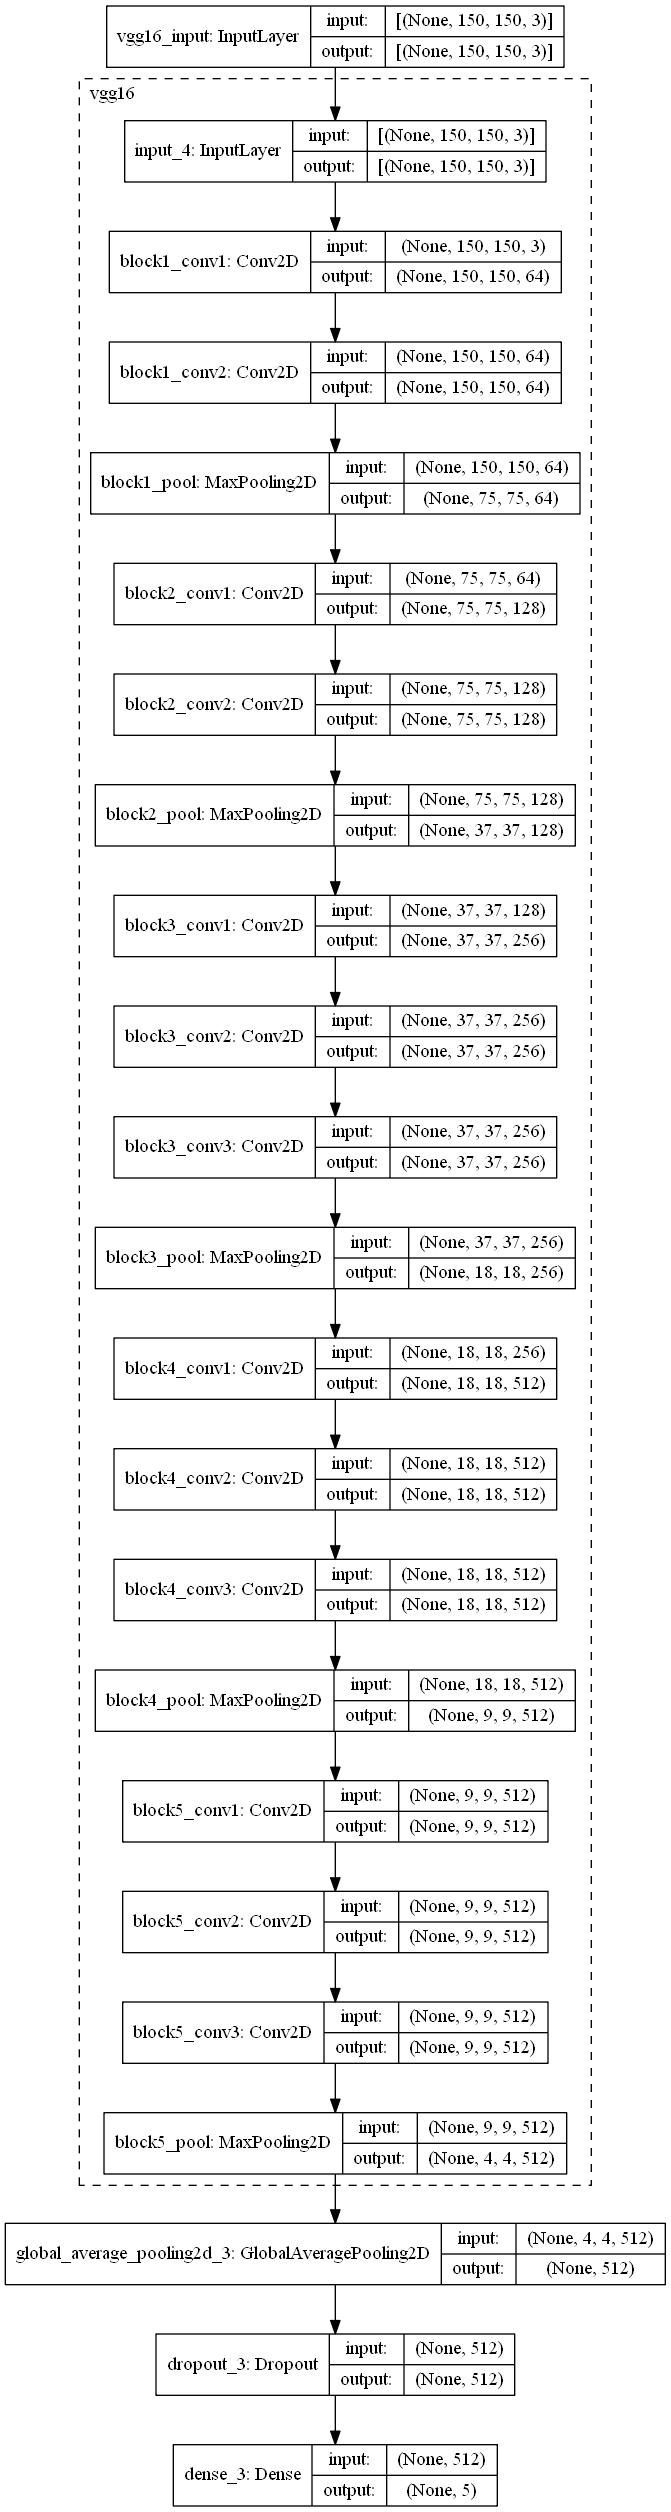

In [41]:
base_model2 = VGG16(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')

for layer in base_model2.layers[:-2]:
    layer.trainable = False
    
for layer in base_model2.layers:
    print(layer,layer.trainable)

model2 = Sequential()
model2.add(base_model2)
model2.add(GlobalAveragePooling2D())
model2.add(Dropout(0.5))
model2.add(Dense(len(shortlisted),activation='softmax'))
model2.summary()

SVG(model_to_dot(model2).create(prog='dot', format='svg'))
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [42]:
checkpoint = ModelCheckpoint(
    './base.model2',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [43]:
#-----------Optimizers-----------#
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-2)
#----------Compile---------------#
model2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
#-----------Training------------#
history = model2.fit_generator(
    img_gen.flow(X_train,y_train,batch_size=16),
    validation_data  = (X_test,y_test),
    validation_steps = 30,
    steps_per_epoch  = 35 ,
    epochs = 20,
    verbose = 1,
    callbacks=callbacks
)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
35/35 [==============================] - 34s 939ms/step - loss: 1.7804 - accuracy: 0.3193 - val_loss: 1.0617 - val_accuracy: 0.5434

Epoch 00001: val_loss improved from inf to 1.06168, saving model to .\base.model2
INFO:tensorflow:Assets written to: .\base.model2\assets
Epoch 2/20
35/35 [==============================] - 29s 847ms/step - loss: 0.9609 - accuracy: 0.5967 - val_loss: 0.8254 - val_accuracy: 0.6679

Epoch 00002: val_loss improved from 1.06168 to 0.82538, saving model to .\base.model2
INFO:tensorflow:Assets written to: .\base.model2\assets
Epoch 3/20
35/35 [==============================] - 29s 825ms/step - loss: 0.6986 - accuracy: 0.7437 - val_loss: 0.7112 - val_accuracy: 0.6981

Epoch 00003: val_loss improved from 0.82538 to 0.71119, saving model to .\base.model2
INFO:tensorflow:Assets written to: .\base.model2\assets
Epoch 4/20
35/35 [==============================] - 28s 818ms/step - loss: 0.7455 - accuracy: 0.7460 - val_loss: 0.6103 - val_accuracy: 0.7585

Ep

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001F74B65CF70> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F74B65C790> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F74D9E1F10> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F726F5C880> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F74BD03280> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F74BD03FD0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F74B87DD30> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F74BD07040> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F74BD04970> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F74BD07A60> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F74BA72A30> False
<tensorflow.python.

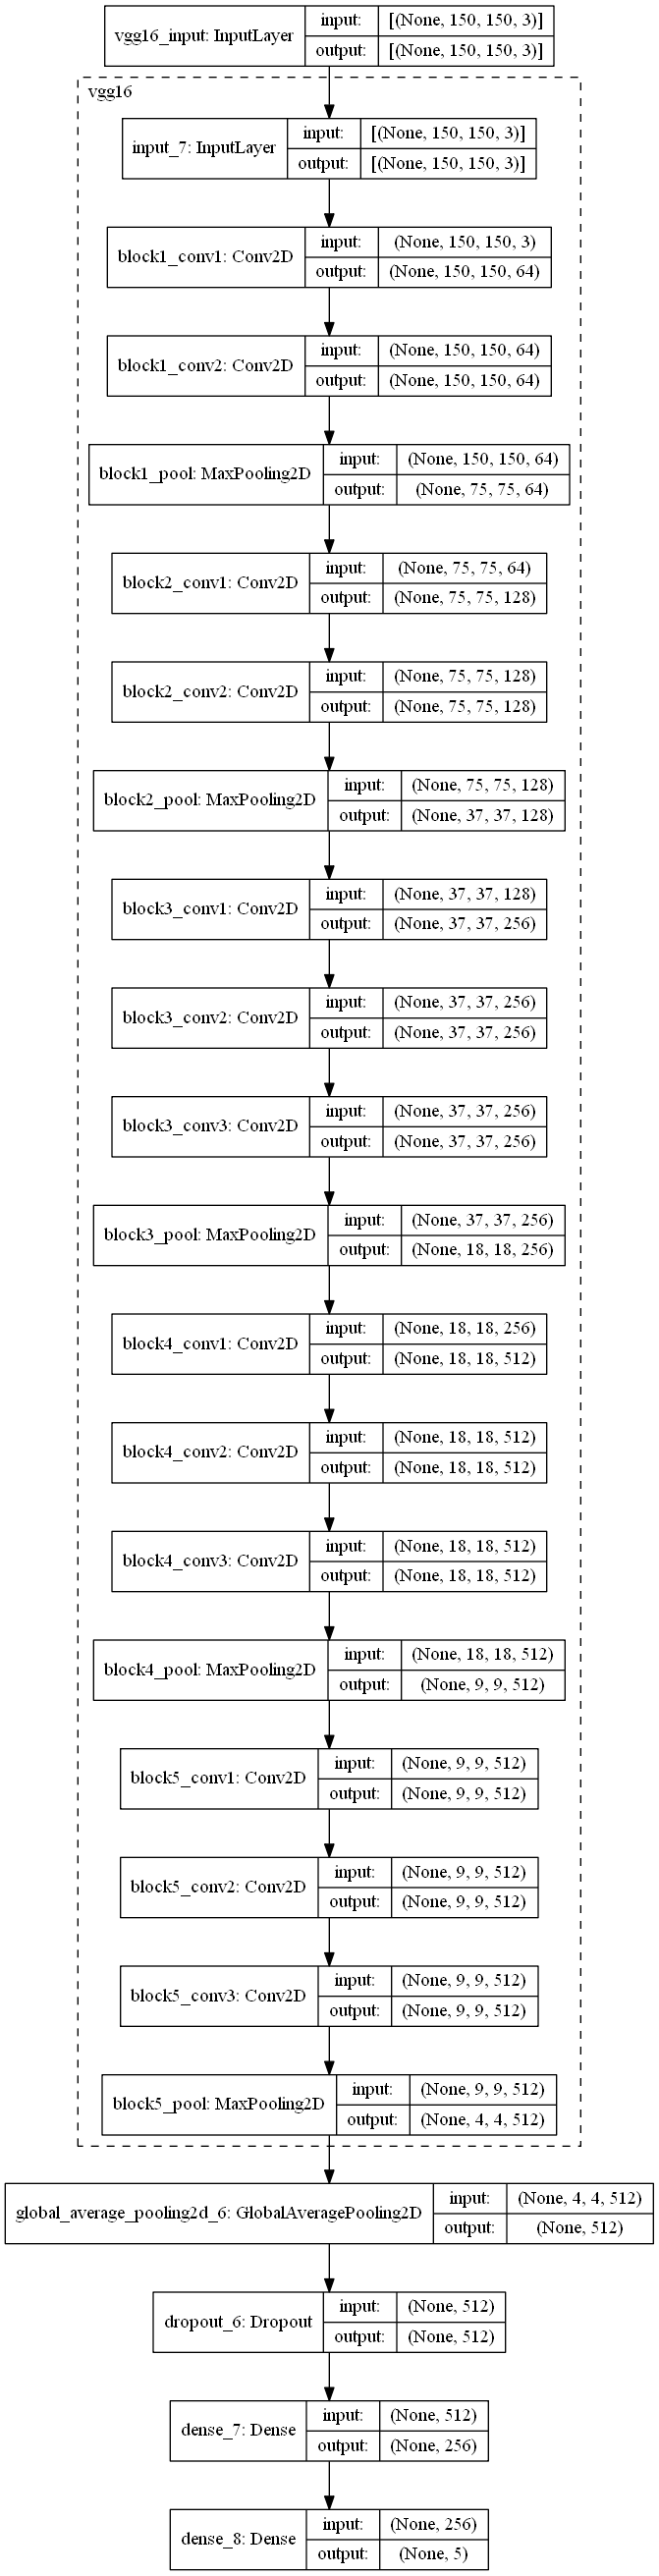

In [46]:
base_model3 = VGG16(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')

for layer in base_model3.layers[:-2]:
    layer.trainable = False
    
for layer in base_model3.layers:
    print(layer,layer.trainable)

model3= Sequential()
model3.add(base_model3)
model3.add(GlobalAveragePooling2D())
model3.add(Dropout(0.5))
model3.add(Dense(256,activation='relu'))
model3.add(Dense(len(shortlisted),activation='softmax'))
model3.summary()

SVG(model_to_dot(model3).create(prog='dot', format='svg'))
plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [47]:
checkpoint = ModelCheckpoint(
    './base.model2',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [48]:
#-----------Optimizers-----------#
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-2)
#----------Compile---------------#
model3.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
#-----------Training------------#
history = model3.fit_generator(
    img_gen.flow(X_train,y_train,batch_size=16),
    validation_data  = (X_test,y_test),
    validation_steps = 30,
    steps_per_epoch  = 35 ,
    epochs = 20,
    verbose = 1,
    callbacks=callbacks
)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
35/35 [==============================] - 23s 650ms/step - loss: 1.9102 - accuracy: 0.2613 - val_loss: 1.1374 - val_accuracy: 0.5887

Epoch 00001: val_loss improved from inf to 1.13736, saving model to .\base.model2
INFO:tensorflow:Assets written to: .\base.model2\assets
Epoch 2/20
35/35 [==============================] - 21s 606ms/step - loss: 1.1791 - accuracy: 0.5295 - val_loss: 0.8946 - val_accuracy: 0.6415

Epoch 00002: val_loss improved from 1.13736 to 0.89462, saving model to .\base.model2
INFO:tensorflow:Assets written to: .\base.model2\assets
Epoch 3/20
35/35 [==============================] - 22s 642ms/step - loss: 0.8323 - accuracy: 0.6824 - val_loss: 0.6923 - val_accuracy: 0.7321

Epoch 00003: val_loss improved from 0.89462 to 0.69231, saving model to .\base.model2
INFO:tensorflow:Assets written to: .\base.model2\assets
Epoch 4/20
35/35 [==============================] - 21s 609ms/step - loss: 0.7167 - accuracy: 0.7361 - val_loss: 0.6311 - val_accuracy: 0.7585

Ep

In [49]:
test_img = 'data/golden.jpg'

path = test_img
img = cv2.imread(path,cv2.IMREAD_COLOR)
img = cv2.resize(img,(imgsize,imgsize))

test_img = np.array(img)
test_img = test_img/255

In [50]:
predict = [np.argmax(model.predict(test_img.reshape(-1, 150, 150, 3)))]
label_encoder.inverse_transform(predict)

array(['golden_retriever'], dtype='<U20')

In [51]:
predict = [np.argmax(model1.predict(test_img.reshape(-1, 150, 150, 3)))]
label_encoder.inverse_transform(predict)

array(['golden_retriever'], dtype='<U20')

In [52]:
predict = [np.argmax(model2.predict(test_img.reshape(-1, 150, 150, 3)))]
label_encoder.inverse_transform(predict)

array(['golden_retriever'], dtype='<U20')

In [53]:
predict = [np.argmax(model3.predict(test_img.reshape(-1, 150, 150, 3)))]
label_encoder.inverse_transform(predict)

array(['golden_retriever'], dtype='<U20')